In [24]:
import pandas as pd
import numpy as np
from scipy.stats import chi2
from sklearn.covariance import EmpiricalCovariance
from sklearn.metrics import confusion_matrix, classification_report
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import warnings
warnings.filterwarnings("ignore")


In [14]:
file_path = '/kaggle/input/wadi-data/'
df_raw = pd.read_csv(file_path + 'WADI_14days_new.csv')
df = df_raw.iloc[:,3:]
atk_raw = pd.read_csv(file_path + 'WADI_attackdataLABLE.csv')
atk = atk_raw.iloc[:-2,3:]
new_header = atk.iloc[0]
atk = atk[1:].reset_index(drop=True)
atk.columns = new_header
cols_to_drop = [47, 48, 83, 84]

dropped_df = df.drop(df.columns[cols_to_drop], axis=1)
dropped_atk = atk.drop(atk.columns[cols_to_drop], axis=1)
dropped_df.fillna(method='bfill', inplace=True)
dropped_atk.drop(columns=['2B_AIT_002_PV'], inplace=True)
dropped_df.drop(columns=['2B_AIT_002_PV'], inplace=True)

df = dropped_df
atk = dropped_atk



In [15]:
FEATURE_TO_MODEL_INDEX = 0 

ANOMALY_COLUMN_NAME = 'Attack LABLE (1:No Attack, -1:Attack)'
NORMAL_LABEL_VALUE = 1
ANOMALY_LABEL_VALUE = -1

ARIMA_ORDER = (5, 1, 0)

RESIDUAL_THRESHOLD_MULTIPLIER = 3.0


In [16]:
def process_feature_and_labels(input_df, df_name, feature_col, is_test_file=False, anomaly_col=None, normal_val=None, anomaly_val=None):
    """Processes a specific feature and optionally labels from a pandas DataFrame."""
    print(f"Processing DataFrame '{df_name}'. Shape: {input_df.shape}")

    if feature_col not in input_df.columns:
        print(f"FATAL ERROR: Feature column '{feature_col}' not found in DataFrame '{df_name}'. Available columns: {input_df.columns.tolist()}")
        return None, None
    
    feature_series = input_df[feature_col].astype(float)
    
    labels = None
    if is_test_file:
        if anomaly_col not in input_df.columns:
            print(f"FATAL ERROR: Anomaly column '{anomaly_col}' not found in DataFrame '{df_name}'.")
            return None, None
        
        raw_labels = input_df[anomaly_col].values
        labels = np.zeros_like(raw_labels, dtype=int)
        labels[raw_labels == anomaly_val] = 1
        labels[raw_labels == normal_val] = 0
        print(f"Processed labels from '{anomaly_col}'. Anomalies (1): {np.sum(labels == 1)}, Normals (0): {np.sum(labels == 0)}")
        
    return feature_series, labels

In [17]:
if FEATURE_TO_MODEL_INDEX >= len(df.columns):
     print(f"FATAL ERROR: FEATURE_TO_MODEL_INDEX {FEATURE_TO_MODEL_INDEX} is out of bounds for DataFrame 'df' which has {len(df.columns)} columns.")
     exit()
FEATURE_TO_MODEL = df.columns[FEATURE_TO_MODEL_INDEX]
print(f"Using feature at index {FEATURE_TO_MODEL_INDEX}, which is column: '{FEATURE_TO_MODEL}'")

Using feature at index 0, which is column: '1_AIT_001_PV'


In [18]:
print("--- Processing Normal Data for Training ---")
normal_feature_series, _ = process_feature_and_labels(df, 'df', FEATURE_TO_MODEL)

print("\n--- Processing Test Data for Evaluation ---")
test_feature_series, test_point_labels = process_feature_and_labels(
    atk, 'atk', FEATURE_TO_MODEL, 
    is_test_file=True, anomaly_col=ANOMALY_COLUMN_NAME, 
    normal_val=NORMAL_LABEL_VALUE, anomaly_val=ANOMALY_LABEL_VALUE
)



--- Processing Normal Data for Training ---
Processing DataFrame 'df'. Shape: (784571, 122)

--- Processing Test Data for Evaluation ---
Processing DataFrame 'atk'. Shape: (172801, 123)
Processed labels from 'Attack LABLE (1:No Attack, -1:Attack)'. Anomalies (1): 9977, Normals (0): 162824


In [29]:
normal_feature_series

0         171.155
1         171.155
2         171.155
3         171.155
4         171.155
           ...   
784566    175.855
784567    175.855
784568    175.855
784569    175.896
784570    175.896
Name: 1_AIT_001_PV, Length: 784571, dtype: float64

In [19]:
arima_model = ARIMA(normal_feature_series, order=ARIMA_ORDER)
arima_model_fitted = arima_model.fit()
train_residuals = arima_model_fitted.resid
mean_train_resid = np.mean(train_residuals)
std_train_resid = np.std(train_residuals)

anomaly_threshold_upper = mean_train_resid + RESIDUAL_THRESHOLD_MULTIPLIER * std_train_resid
anomaly_threshold_lower = mean_train_resid - RESIDUAL_THRESHOLD_MULTIPLIER * std_train_resid

test_predictions = arima_model_fitted.forecast(steps=len(test_feature_series))

test_residuals = test_feature_series.values - test_predictions.values

predicted_anomalies = ((test_residuals > anomaly_threshold_upper) | (test_residuals < anomaly_threshold_lower)).astype(int)

y_true = test_point_labels
y_pred = predicted_anomalies
y_scores = test_residuals

In [25]:
arr = y_scores.reshape(-1, 1)

scaler_for_error = MinMaxScaler(feature_range=(0, 1))
scaled_arr = scaler_for_error.fit_transform(arr)

y_scores = scaled_arr.flatten().tolist()

Accuracy	 0.2605135386947992
Precision	 0.05028973667936571
Recall	 0.6602185025558786
f1 score	 0.09346046340044553
cohen_kappa_score	 -0.015503731059964165
auc	 0.5329557532760174
roc_auc	 0.5329557532760174


Text(0.5, 23.52222222222222, 'Ground Truth')

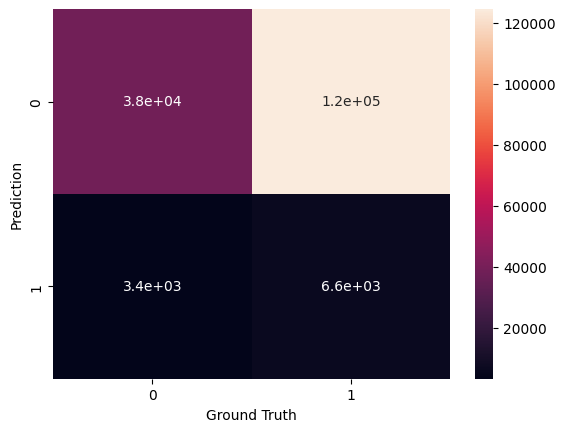

In [30]:
import seaborn as sns
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
accuracy = (tp + tn) / (tn + fp + fn + tp)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = (2 * precision * recall)/ (precision + recall)
cohen_kappa_score = cohen_kappa_score(y_true, y_pred)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_true, y_scores)
auc_val = auc(false_positive_rate, true_positive_rate)
roc_auc_val = roc_auc_score(y_true, y_scores)

print('Accuracy\t', accuracy)
print('Precision\t', precision)
print('Recall\t', recall)
print('f1 score\t', f1_score)
print('cohen_kappa_score\t', cohen_kappa_score)
print('auc\t', auc_val)
print('roc_auc\t', roc_auc_val)

sns.heatmap(confusion_matrix(y_true, y_pred), annot=True)
plt.ylabel('Prediction')
plt.xlabel('Ground Truth')

In [31]:
from sklearn.metrics import (
    precision_recall_curve,
    roc_curve,
    auc,
    average_precision_score
)

precision, recall, _ = precision_recall_curve(y_true, y_scores)
pr_auc = average_precision_score(y_true, y_scores)
print(f"PR-AUC: {pr_auc:.4f}")

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)
print(f"ROC-AUC: {roc_auc:.4f}")

PR-AUC: 0.1081
ROC-AUC: 0.5330


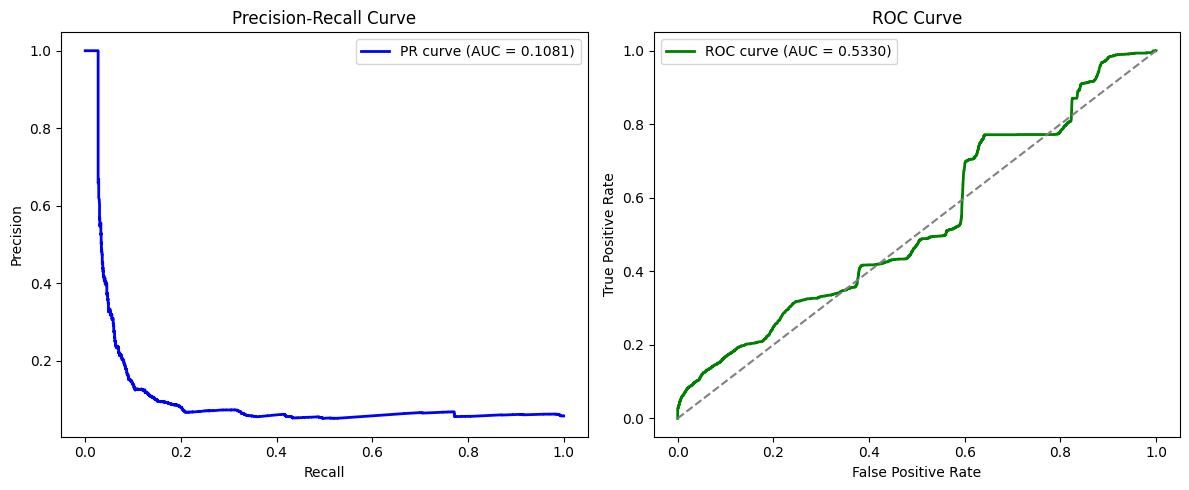

In [32]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

# Plot ROC curve
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='green', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

plt.tight_layout()
plt.show()